In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# remove pandas colomn limit
pd.set_option('display.max_columns', None)


* Im going to create one data frame with all the points and features and then I will cluster them for each segement using a time series aproch

* then i will use those cluster lables for the second data frame where it have a row for each segment , with speed acceleration and other features and their mean , median , MAX , MIN and std

* and i will use that second dataframe to do a clustering based on driving behavior , 

* then i will try to find a meaning those clusters have. then for the training dataset i have to train a clasifire that will predict the cluster of each future segment

* then using those data i will pridict the arrival time.

* if that was not enough i will train a regression model to predict the speed , acceleration and other features for each new upcoming segemnt, and then i will use that to predict the arrival time


In [2]:
# import csv DataOut\bus_running_times_feature_added_all_moddedDF.csv
running_time_features = pd.read_csv('../DataOut/bus_running_times_feature_added_all_moddedDF.csv')
# read csv DataOut\bus_trip_all_points_moddedDF.csv 
bus_trip_speed_and_other_features = pd.read_csv('../DataOut/bus_trip_all_points_with_acceleration_and_radial_acceleration_and_distance_and_accDiff.csv')

In [3]:
# # select a random set of 10 trip ids , sed a known seed for reproducibility
# np.random.seed(42)
# trip_ids = np.random.choice(bus_trip_speed_and_other_features.trip_id.unique(), 10, replace=False)
# # select only the trips with the selected trip ids
# bus_trip_speed_and_other_features = bus_trip_speed_and_other_features[bus_trip_speed_and_other_features.trip_id.isin(trip_ids)]
# running_time_features= running_time_features[running_time_features.trip_id.isin(trip_ids)]
# # reset the index
# bus_trip_speed_and_other_features.reset_index(drop=True, inplace=True)
# running_time_features.reset_index(drop=True, inplace=True)

# trip_ids

In [4]:
# running_time_features=running_time_features[running_time_features['trip_id'].isin(trip_ids)]
# bus_trip_speed_and_other_features=bus_trip_speed_and_other_features[bus_trip_speed_and_other_features['trip_id'].isin(trip_ids)]

In [5]:
useless_features=['id','geometry','count',]
bus_trip_speed_and_other_features=bus_trip_speed_and_other_features.drop(useless_features,axis=1)

In [6]:
bus_trip_speed_and_other_features

deviceid           devicetime  latitude  longitude     speed  \
0             116  2021-10-16 08:03:19  7.293068  80.636430  14.03890   
1             116  2021-10-16 08:03:34  7.293043  80.637552  10.25920   
2             116  2021-10-16 08:03:49  7.292725  80.637707   7.55940   
3             116  2021-10-16 08:04:04  7.292292  80.637663   3.77970   
4             116  2021-10-16 08:04:19  7.291640  80.637455   9.17927   
...           ...                  ...       ...        ...       ...   
1159802       262  2022-08-09 10:55:05  7.290370  80.638812  20.51840   
1159803       262  2022-08-09 10:55:37  7.291380  80.637410   7.55940   
1159804       262  2022-08-09 10:55:38  7.291392  80.637387   7.55940   
1159805       262  2022-08-09 10:55:53  7.291295  80.636463  12.95900   
1159806       262  2022-08-09 10:56:15  7.291702  80.635213   5.93953   

               date      time bus_stop  trip_id  direction  acceleration  \
0        2021-10-16  08:03:19      NaN      2.0          1      0.323975   
1        2021-10-16  08:03:34      NaN      2.0          1     -0.251980   
2        2021-10-16  08:03:49      NaN      2.0          1     -0.179987   
3        2021-10-16  08:04:04      NaN      2.0          1     -0.251980   
4        2021-10-16  08:04:19      101      2.0          1      0.359971   
...             ...       ...      ...      ...        ...           ...   
1159802  2022-08-09  10:55:05      NaN   5586.0          2     -0.539900   
1159803  2022-08-09  10:55:37      NaN   5586.0          2     -0.404969   
1159804  2022-08-09  10:55:38      NaN   5586.0          2      0.000000   
1159805  2022-08-09  10:55:53      NaN   5586.0          2      0.359973   
1159806  2022-08-09  10:56:15     BT01   5586.0          2     -0.319067   

         radial_acceleration  distance_from_start        time_diff  acc_diff  \
0                   0.000000             0.000000              NaN       NaN   
1                   1.278067           123.738485  0 days 00:00:15 -0.575955   
2                   0.722300           163.044397  0 days 00:00:15  0.071993   
3                   0.048332           211.472339  0 days 00:00:15 -0.071993   
4                   1.052222           287.492821  0 days 00:00:15  0.611951   
...                      ...                  ...              ...       ...   
1159802             4.312238         16062.472333  0 days 00:00:01 -0.694171   
1159803             0.096588         16253.551165  0 days 00:00:32  0.134931   
1159804             0.588683         16256.436454  0 days 00:00:01  0.404969   
1159805             0.563965         16358.837456  0 days 00:00:15  0.359973   
1159806             0.000000         16503.931061  0 days 00:00:22 -0.679040   

         acceleration_der  
0                0.000000  
1               -0.038397  
2                0.004800  
3               -0.004800  
4                0.040797  
...                   ...  
1159802         -0.694171  
1159803          0.004217  
1159804          0.404969  
1159805          0.023998  
1159806         -0.030865  

[1159807 rows x 16 columns]

In [7]:
running_time_features

trip_id  deviceid  direction  segment        date start_time  \
0        4890.0     262.0        1.0      1.0  2021-10-01   06:39:49   
1        4890.0     262.0        1.0      2.0  2021-10-01   06:42:12   
2        4890.0     262.0        1.0      3.0  2021-10-01   06:45:42   
3        4890.0     262.0        1.0      4.0  2021-10-01   06:54:04   
4        4890.0     262.0        1.0      5.0  2021-10-01   06:57:19   
...         ...       ...        ...      ...         ...        ...   
150701   3462.0     123.0        2.0     28.0  2022-10-31   18:45:44   
150702   3462.0     123.0        2.0     29.0  2022-10-31   18:47:38   
150703   3462.0     123.0        2.0     30.0  2022-10-31   18:50:56   
150704   3462.0     123.0        2.0     31.0  2022-10-31   18:56:48   
150705   3462.0     123.0        2.0     32.0  2022-10-31   18:57:49   

        end_time         run_time  run_time_in_seconds  length  day_of_week  \
0       06:40:58  0 days 00:01:09                 69.0  0.6261          4.0   
1       06:45:42  0 days 00:03:30                210.0  1.2808          4.0   
2       06:53:58  0 days 00:08:16                496.0  2.1125          4.0   
3       06:57:19  0 days 00:03:15                195.0  1.5513          4.0   
4       06:58:56  0 days 00:01:37                 97.0  0.8450          4.0   
...          ...              ...                  ...     ...          ...   
150701  18:47:23          0:01:39                 99.0  0.8700          0.0   
150702  18:50:23          0:02:45                165.0  1.4000          0.0   
150703  18:56:33          0:05:37                337.0  2.5600          0.0   
150704  18:57:34          0:00:46                 46.0  0.4200          0.0   
150705  19:00:13          0:02:24                144.0  1.3000          0.0   

        time_of_day  Sunday/holiday  saturday  weekday/end  week_no  rt(w-1)  \
0              6.50             0.0         0            1      1.0     96.0   
1              6.50             0.0         0            1      1.0    247.0   
2              6.75             0.0         0            1      1.0    506.0   
3              6.75             0.0         0            1      1.0    192.0   
4              6.75             0.0         0            1      1.0    114.0   
...             ...             ...       ...          ...      ...      ...   
150701        18.75             0.0         0            1     42.0    120.0   
150702        18.75             0.0         0            1     42.0    218.0   
150703        18.75             0.0         0            1     42.0    391.0   
150704        18.75             0.0         0            1     42.0     65.0   
150705        18.75             0.0         0            1     42.0    172.0   

        rt(w-2)  rt(w-3)  rt(t-1)  rt(t-2)  rt(n-1)  rt(n-2)  rt(n-3)  \
0          96.0     96.0     96.0     96.0     96.0     96.0     96.0   
1         247.0    247.0    247.0    247.0     69.0    247.0    247.0   
2         506.0    506.0    506.0    506.0    210.0     69.0    506.0   
3         192.0    192.0    192.0    192.0    496.0    210.0     69.0   
4         114.0    114.0    114.0    114.0    195.0    496.0    210.0   
...         ...      ...      ...      ...      ...      ...      ...   
150701    120.0    120.0    120.0    120.0     63.0    156.0    197.0   
150702    218.0    218.0    218.0    218.0     99.0     63.0    156.0   
150703    391.0    391.0    391.0    391.0    165.0     99.0     63.0   
150704     65.0     65.0     65.0     65.0    337.0    165.0     99.0   
150705    172.0    172.0    172.0    172.0     46.0    337.0    165.0   

        hour_of_day   day  month  temp  precip  windspeed        conditions  \
0               6.0   1.0   10.0  20.0     0.0        6.1  Partially cloudy   
1               6.0   1.0   10.0  20.0     0.0        6.1  Partially cloudy   
2               6.0   1.0   10.0  20.0     0.0        6.1  Partially cloudy   
3               6.0   1.0   10.0  20.0  

In [8]:
#print unique set of trip ids where direction is equal to 2
print(running_time_features[running_time_features['direction']==2]['trip_id'].unique())

[2369. 4891. 6544. ... 4889. 5908. 3462.]


Insert segment column 

In [9]:
# set Nan values in bus_stop column to 0
bus_trip_speed_and_other_features['bus_stop']=bus_trip_speed_and_other_features['bus_stop'].fillna(0)

In [10]:
ayyas_df = pd.read_csv('../DataOut/bus_running_times_feature_added_all_moddedDF.csv')

In [11]:

bus_trip_speed_and_other_features['segment'] = 0
for x in bus_trip_speed_and_other_features.trip_id.unique():
    df = bus_trip_speed_and_other_features[bus_trip_speed_and_other_features['trip_id'] == x]
    ayyas_tid_df = ayyas_df[ayyas_df['trip_id'] == x]

    for index, row in df.iterrows():
        for index2, row2 in ayyas_tid_df.iterrows():
            # print(row)
            print_counter = 0
            # Check if 'start_time' and 'end_time' are not null (not missing values)
            if pd.notna(row2['start_time']) and pd.notna(row2['end_time']):
                if row2['start_time'] <= row['time'] and row['time'] <= row2['end_time']:
                    bus_trip_speed_and_other_features.loc[index, 'segment'] = row2['segment']
                    break
                        

In [12]:
bus_trip_speed_and_other_features

deviceid           devicetime  latitude  longitude     speed  \
0             116  2021-10-16 08:03:19  7.293068  80.636430  14.03890   
1             116  2021-10-16 08:03:34  7.293043  80.637552  10.25920   
2             116  2021-10-16 08:03:49  7.292725  80.637707   7.55940   
3             116  2021-10-16 08:04:04  7.292292  80.637663   3.77970   
4             116  2021-10-16 08:04:19  7.291640  80.637455   9.17927   
...           ...                  ...       ...        ...       ...   
1159802       262  2022-08-09 10:55:05  7.290370  80.638812  20.51840   
1159803       262  2022-08-09 10:55:37  7.291380  80.637410   7.55940   
1159804       262  2022-08-09 10:55:38  7.291392  80.637387   7.55940   
1159805       262  2022-08-09 10:55:53  7.291295  80.636463  12.95900   
1159806       262  2022-08-09 10:56:15  7.291702  80.635213   5.93953   

               date      time bus_stop  trip_id  direction  acceleration  \
0        2021-10-16  08:03:19        0      2.0          1      0.323975   
1        2021-10-16  08:03:34        0      2.0          1     -0.251980   
2        2021-10-16  08:03:49        0      2.0          1     -0.179987   
3        2021-10-16  08:04:04        0      2.0          1     -0.251980   
4        2021-10-16  08:04:19      101      2.0          1      0.359971   
...             ...       ...      ...      ...        ...           ...   
1159802  2022-08-09  10:55:05        0   5586.0          2     -0.539900   
1159803  2022-08-09  10:55:37        0   5586.0          2     -0.404969   
1159804  2022-08-09  10:55:38        0   5586.0          2      0.000000   
1159805  2022-08-09  10:55:53        0   5586.0          2      0.359973   
1159806  2022-08-09  10:56:15     BT01   5586.0          2     -0.319067   

         radial_acceleration  distance_from_start        time_diff  acc_diff  \
0                   0.000000             0.000000              NaN       NaN   
1                   1.278067           123.738485  0 days 00:00:15 -0.575955   
2                   0.722300           163.044397  0 days 00:00:15  0.071993   
3                   0.048332           211.472339  0 days 00:00:15 -0.071993   
4                   1.052222           287.492821  0 days 00:00:15  0.611951   
...                      ...                  ...              ...       ...   
1159802             4.312238         16062.472333  0 days 00:00:01 -0.694171   
1159803             0.096588         16253.551165  0 days 00:00:32  0.134931   
1159804             0.588683         16256.436454  0 days 00:00:01  0.404969   
1159805             0.563965         16358.837456  0 days 00:00:15  0.359973   
1159806             0.000000         16503.931061  0 days 00:00:22 -0.679040   

         acceleration_der  segment  
0                0.000000        1  
1               -0.038397        1  
2                0.004800        1  
3               -0.004800        1  
4                0.040797        1  
...                   ...      ...  
1159802         -0.694171        0  
1159803          0.004217        0  
1159804          0.404969        0  
1159805          0.023998        0  
1159806         -0.030865        0  

[1159807 rows x 17 columns]

# TS cluster segemnts

In [13]:
df_for_seg_ts_clustering = bus_trip_speed_and_other_features[['trip_id','segment','time','distance_from_start','speed','acceleration','radial_acceleration','acceleration_der']]
# drop rows where segment is 0
df_for_seg_ts_clustering = df_for_seg_ts_clustering[df_for_seg_ts_clustering['segment'] != 0]
df_for_seg_ts_clustering

trip_id  segment      time  distance_from_start     speed  \
0            2.0        1  08:03:19             0.000000  14.03890   
1            2.0        1  08:03:34           123.738485  10.25920   
2            2.0        1  08:03:49           163.044397   7.55940   
3            2.0        1  08:04:04           211.472339   3.77970   
4            2.0        1  08:04:19           287.492821   9.17927   
...          ...      ...       ...                  ...       ...   
1159785   5586.0       32  10:51:08         14453.540895  12.95900   
1159786   5586.0       32  10:51:09         14460.806246  12.41900   
1159787   5586.0       32  10:51:42         14641.281348   6.47948   
1159788   5586.0       32  10:51:43         14647.953044   7.01944   
1159789   5586.0       32  10:52:13         14871.244917   5.39957   

         acceleration  radial_acceleration  acceleration_der  
0            0.323975             0.000000          0.000000  
1           -0.251980             1.278067         -0.038397  
2           -0.179987             0.722300          0.004800  
3           -0.251980             0.048332         -0.004800  
4            0.359971             1.052222          0.040797  
...               ...                  ...               ...  
1159785      0.016364             1.365805          0.000496  
1159786     -0.540000             1.315046         -0.556364  
1159787     -0.179985             0.372508          0.010910  
1159788      0.539960             0.292198          0.719945  
1159789     -0.053996             0.149243         -0.019799  

[1071556 rows x 8 columns]

In [14]:
import pandas as pd

# Assuming df_for_seg_ts_clustering is your DataFrame

# Convert the 'time' column to datetime objects
df_for_seg_ts_clustering['time'] = pd.to_datetime(df_for_seg_ts_clustering['time'], format='%H:%M:%S')

# Group by 'trip_id' and 'segment'
grouped = df_for_seg_ts_clustering.groupby(['trip_id', 'segment'])

# Define a function to calculate the time difference in seconds within each group
def calculate_time_diff(group):
    group['time'] = (group['time'] - group['time'].min()).dt.total_seconds().astype(int)
    return group

# Apply the function to each group and concatenate the results
df_for_seg_ts_clustering = grouped.apply(calculate_time_diff)


In [15]:
# Print the resulting DataFrame
df_for_seg_ts_clustering[df_for_seg_ts_clustering['trip_id'] == 476].head(50)

trip_id  segment  time  distance_from_start     speed  \
trip_id segment                                                                
476.0   1       49714    476.0        1     0            26.470880   7.01944   
                49715    476.0        1    15           107.955285  11.33910   
                49716    476.0        1    30           195.949844   9.71923   
                49717    476.0        1    45           227.981921   0.00000   
                49718    476.0        1    60           277.806275   7.55940   
                49719    476.0        1    75           354.258956   8.63931   
                49720    476.0        1    90           402.029744   0.00000   
        2       49723    476.0        2     0           514.573434   9.71923   
                49724    476.0        2    15           601.448165  10.79910   
                49725    476.0        2    30           681.541615  10.79910   
                49726    476.0        2    45           749.130042  12.95900   
                49727    476.0        2    60           838.471877   7.01944   
                49728    476.0        2    75           894.327403   8.09935   
                49729    476.0        2    90           967.251675   6.47948   
                49730    476.0        2   105          1022.403368   3.23974   
                49731    476.0        2   120          1037.657317   3.77970   
                49732    476.0        2   135          1084.005276   3.23974   
                49733    476.0        2   150          1107.629859   0.00000   
                49734    476.0        2   165          1150.832374   9.17927   
                49735    476.0        2   180          1203.969250   0.00000   
                49736    476.0        2   195          1247.234831   9.71923   
                49737    476.0        2   210          1325.288611   8.63931   
                49738    476.0        2   225          1403.058138  10.25920   
                49739    476.0        2   240          1476.638818   8.63931   
        3       49740    476.0        3     0          1551.447817  12.41900   
                49741    476.0        3    15          1652.978469  17.81860   
                49742    476.0        3    30          1775.062135   6.47948   
                49743    476.0        3    45          1803.744707   0.00000   
                49744    476.0        3    60          1803.744707   0.00000   
                49745    476.0        3    75          1831.498554   5.39957   
                49746    476.0        3    90          1912.500198  16.19870   
                49747    476.0        3   102          1987.182549   0.00000   
                49748    476.0        3   117          2067.645374  15.65880   
                49749    476.0        3   132          2190.744896  14.03890   
                49750    476.0        3   147          2275.465680   9.71923   
                49751    476.0        3   162          2333.870773   0.00000   
                49752    476.0        3   177          2404.438232  10.25920   
                49753    476.0        3   192          2466.398373   9.17927   
                49754    476.0        3   207          2548.879145   9.71923   
                49755    476.0        3   222          2606.369007   6.47948   
                49756    476.0        3   237          2633.410795   0.00000   
                49757    476.0        3   252          2661.947482   7.01944   
                49758    476.0        3   267          2715.466487   0.00000   
                49759    476.0        3   282          2725.084474   5.39957   
                49760    476.0        3   297          2814.905940  16.19870   
                49761    476.0        3   312          2923.853075  11.87910   
                49762    476.0        3   327          3015.741341   8.63931   
                49763    476.0        3   342          3073.549606   7.01944   
                49764  

In [16]:
df_for_seg_ts_clustering=df_for_seg_ts_clustering.drop(['trip_id','segment'],axis=1)
df_for_seg_ts_clustering=df_for_seg_ts_clustering.reset_index()
# drop level_2 column
df_for_seg_ts_clustering = df_for_seg_ts_clustering.drop('level_2',axis=1)


In [17]:
# Group by 'segment' and calculate the maximum time in seconds for each segment within each trip_id
grouped = df_for_seg_ts_clustering.groupby(['segment', 'trip_id'])['time'].max()

# Calculate the average total time length for each segment
segment_avg_times = grouped.groupby('segment').mean()

# Round the mean value to the nearest 15th multiplier integer
segment_avg_times_rounded = (segment_avg_times / 15).round() * 15 

# Convert the result to a dictionary
segment_avg_times_dict = segment_avg_times_rounded.to_dict()

# Print the dictionary
print(segment_avg_times_dict)


{1: 105.0, 2: 240.0, 3: 450.0, 4: 225.0, 5: 120.0, 6: 210.0, 7: 45.0, 8: 75.0, 9: 30.0, 10: 165.0, 11: 195.0, 12: 165.0, 13: 150.0, 14: 105.0, 15: 330.0, 21: 390.0, 22: 120.0, 23: 195.0, 24: 180.0, 25: 240.0, 26: 135.0, 27: 45.0, 28: 135.0, 29: 195.0, 30: 420.0, 31: 60.0, 32: 225.0, 33: 225.0, 34: 90.0}


In [18]:
df_for_seg_ts_clustering

trip_id  segment  time  distance_from_start     speed  acceleration  \
0            1.0       21     0             0.000000  19.43850      0.827937   
1            1.0       21    15           164.372574  26.45790      0.467960   
2            1.0       21    21           218.905086   5.93953     -3.419728   
3            1.0       21    36           235.708681  11.33910      0.359971   
4            1.0       21    51           406.124140  23.21820      0.791940   
...          ...      ...   ...                  ...       ...           ...   
1071551   5587.0       15   587         16959.169925   2.15983     -0.057853   
1071552   5587.0       15   622         17123.789768   2.15983      0.000000   
1071553   5587.0       15   623         17175.357332   2.69978      0.539950   
1071554   5587.0       15   627         17309.762484   5.39957      0.674947   
1071555   5587.0       15   692         17671.097141   2.15983     -0.049842   

         radial_acceleration  acceleration_der  
0                   0.000000          0.000000  
1                   5.118394         -0.023998  
2                   0.160064         -0.647948  
3                   0.876561          0.251980  
4                   1.501459          0.028798  
...                      ...               ...  
1071551             0.017268         -0.014922  
1071552             0.050073          0.001653  
1071553             0.056444          0.539950  
1071554             0.062833          0.033749  
1071555             0.000000         -0.011151  

[1071556 rows x 8 columns]

In [19]:
import pandas as pd
import numpy as np

# Assuming df_for_seg_ts_clustering is your DataFrame with the time adjustments
# Assuming segment_avg_times_dict is the dictionary of rounded average times you calculated earlier

# Create an empty list to store dictionaries of rows
adjusted_rows = []

for tid in df_for_seg_ts_clustering['trip_id'].unique():
    for seg in df_for_seg_ts_clustering[df_for_seg_ts_clustering['trip_id'] == tid]['segment'].unique():
        # Iterate through i by steps of 15 from 0 to the maximum time in seconds for the segment
        for i in range(0, int(segment_avg_times_dict[seg])+15, 15):
            # Check if the row in df_for_seg_ts_clustering where trip_id is equal to tid, segment is equal to seg, and time is equal to i exists
            if df_for_seg_ts_clustering[(df_for_seg_ts_clustering['trip_id'] == tid) & (df_for_seg_ts_clustering['segment'] == seg) & (df_for_seg_ts_clustering['time'] == i)].shape[0] > 0:
                # Append the row to the list of adjusted rows
                adjusted_rows.append(df_for_seg_ts_clustering[(df_for_seg_ts_clustering['trip_id'] == tid) & (df_for_seg_ts_clustering['segment'] == seg) & (df_for_seg_ts_clustering['time'] == i)].iloc[0].to_dict())
            else:
                # Create a new dictionary with the same trip_id, segment, and time equal to i and append it to the list of adjusted rows
                adjusted_rows.append({'trip_id': tid, 'segment': seg, 'time': i})

# Create a DataFrame from the list of dictionaries
adjusted_df = pd.DataFrame(adjusted_rows)

# Sort the adjusted DataFrame
adjusted_df.sort_values(by=['trip_id', 'segment', 'time'], inplace=True)

# Reset the index
adjusted_df.reset_index(drop=True, inplace=True)

# Print the adjusted DataFrame
adjusted_df

trip_id  segment   time  distance_from_start    speed  acceleration  \
0           1.0     21.0    0.0             0.000000  19.4385      0.827937   
1           1.0     21.0   15.0           164.372574  26.4579      0.467960   
2           1.0     21.0   30.0                  NaN      NaN           NaN   
3           1.0     21.0   45.0                  NaN      NaN           NaN   
4           1.0     21.0   60.0                  NaN      NaN           NaN   
...         ...      ...    ...                  ...      ...           ...   
955904   5587.0     15.0  270.0                  NaN      NaN           NaN   
955905   5587.0     15.0  285.0                  NaN      NaN           NaN   
955906   5587.0     15.0  300.0                  NaN      NaN           NaN   
955907   5587.0     15.0  315.0                  NaN      NaN           NaN   
955908   5587.0     15.0  330.0                  NaN      NaN           NaN   

        radial_acceleration  acceleration_der  
0                  0.000000          0.000000  
1                  5.118394         -0.023998  
2                       NaN               NaN  
3                       NaN               NaN  
4                       NaN               NaN  
...                     ...               ...  
955904                  NaN               NaN  
955905                  NaN               NaN  
955906                  NaN               NaN  
955907                  NaN               NaN  
955908                  NaN               NaN  

[955909 rows x 8 columns]

In [21]:
# save adjestted_df to  a csv
adjusted_df.to_csv('../DataOut/adjusted_df.csv',index=False)

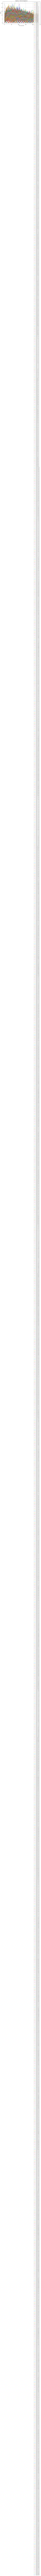

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'adjusted_df' that contains your data

# Filter the DataFrame for segment 2
segment_2_data = adjusted_df[adjusted_df['segment'] == 2]

# Group the data by 'trip_id'
grouped_data = segment_2_data.groupby('trip_id')

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate through each group (trip_id) and plot speed vs. time
for trip_id, group in grouped_data:
    ax.plot(group['time'], group['speed'], label=f'Trip {trip_id}')

# Set labels and title
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Speed')
ax.set_title('Speed vs. Time for Segment 2')

# Add a legend
ax.legend()

# Show the plot
plt.grid()
plt.show()
